# Tutorial
This is a very basic tutorial of segmentation and reconstruction in SEM.  Here, we use a simple 2-d embedding space as it is easy to visualize.  For the purpose of this tutorial, we do not consider structured embedding space (the HRR).

In [ ]:
# ## un-comment out if running locally

# import os
# os.chdir('../')

In [1]:
## if running locally, comment out the following code

!git clone https://github.com/nicktfranklin/SEM.git
import os
os.chdir('./SEM/')

!pip install tensorflow==1.9
!pip install keras==2.2

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import SEM
from sklearn import metrics
sns.set_context('talk')

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0
TensorFlow Check Passed


Here, we create a toy data set: 2 events, both linear systems in a simple 2-D space with different ammounts of noise

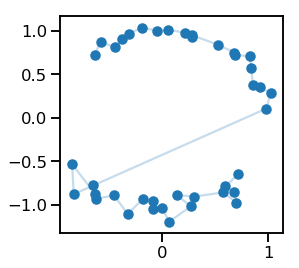

In [4]:
np.random.seed(0)  # for consistency, set the seed

def rotation_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

A = rotation_matrix( -np.pi/2 * 0.075)
x_train = [ np.array([[-1, 1]]).T / np.sqrt(2)]

for _ in range(19):
    x_train.append(np.matmul(A, x_train[-1]))

A = rotation_matrix( np.pi/2 * 0.055)
x_train.append(np.array([[-1, -1]]).T / np.sqrt(2))
for _ in range(19):
    x_train.append(np.matmul(A, x_train[-1]))

x_train = np.concatenate(x_train, axis=1).T

# add observation noise
x_train[:20, :] += np.random.randn(20, 2) * 0.04
x_train[20:, :] += np.random.randn(20, 2) * 0.12

plt.figure(figsize=(4,4))
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.plot(x_train[:, 0], x_train[:, 1], alpha=0.25)

# label of the true identies
y = np.concatenate([np.zeros(20), np.ones(20)])

# Segmentation
Below, we set the parameters for segmentation.  We generally only need to change the sticky-CRP parameters and the prior variance of the event model.  The rest is set behind the scenes.  Of the two, the prior variance is typically the most imporant

In [6]:
lmda = 10.0  # stickyness parameter
alfa = .01  # concentration parameter

# prior over the event varaiance.  
var_scale = .6
var_df = 10

# These are parameters of the event model, not SEM, and they are stored in a seperate dictionary
f_opts = dict(var_scale0=var_scale, var_df0=var_df)

# store all of the SEM parameters and the event model parameters in a dictionary
sem_kwargs = dict(lmda=lmda, alfa=alfa, f_opts=f_opts)


In [7]:
help(SEM)

Help on class SEM in module models.sem:

class SEM(__builtin__.object)
 |  This port of SAM's code (done with a different programming logic)
 |  in python. More documentation to come!
 |  
 |  Methods defined here:
 |  
 |  __init__(self, lmda=1.0, alfa=10.0, f_class=<class 'models.event_models.GRUEvent'>, f_opts=None)
 |      Parameters
 |      ----------
 |      
 |      lmda: float
 |          sCRP stickiness parameter
 |      
 |      alfa: float
 |          sCRP concentration parameter
 |      
 |      f_class: class
 |          object class that has the functions "predict" and "update".
 |          used as the event model
 |      
 |      f_opts: dictionary
 |          kwargs for initializing f_class
 |  
 |  clear_event_models(self)
 |  
 |  init_for_boundaries(self, list_events)
 |  
 |  pretrain(self, x, event_types, event_boundaries, progress_bar=True, leave_progress_bar=True)
 |      Pretrain a bunch of event models on sequence of scenes X
 |      with corresponding event la

In [8]:
# run segmentation
sem_model = SEM(**sem_kwargs)
post = sem_model.run(x_train)

Run SEM: 100%|██████████| 40/40 [00:09<00:00,  4.11it/s]


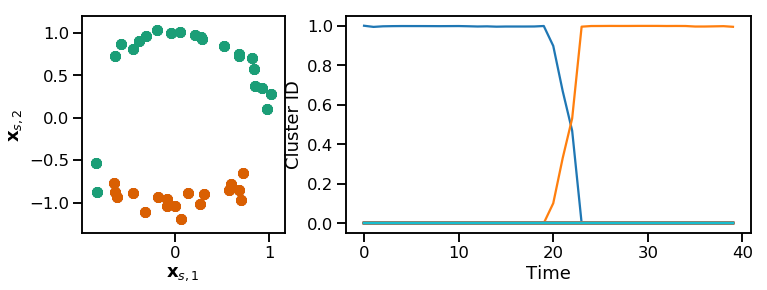

In [9]:
# plot results
def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
plot_segmentation(post, y)

In [10]:
y_hat = np.argmax(post, axis=1)
print "Adjusted Mutual Info:", metrics.adjusted_mutual_info_score(y, y_hat)
print "Adjusted Rand Score: ", metrics.adjusted_rand_score(y, y_hat)
print 
print y_hat

Adjusted Mutual Info: 0.7536569433236987
Adjusted Rand Score:  0.805051302289

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


/Users/nicholasfranklin/anaconda3/envs/sem/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


# Memory
----

Now, we move on to some simple demonstrations of memory smoothing

## Created corrupted memory trace
The software has a buildin function for generating corrupted memory traces consistent with the model 

In [11]:
from models.memory import create_corrupted_trace
help(create_corrupted_trace)

Help on function create_corrupted_trace in module models.memory:

create_corrupted_trace(x, e, tau, epsilon_e, b, return_random_draws_of_p_e=False)
    create a corrupted memory trace from feature vectors and event labels
    
    :param x:           np.array of size nXd, featur vectors
    :param e:           np.array of length n, event labels
    :param tau:         float, feature corruption
    :param epsilon_e:   float, event label precision
    :param b:           int, time index corruption
    
    :return y_mem: list of corrupted memory tuples:



In [12]:
epsilon_e = 0.25 # event label precision (1 - zero/one loss probability)
tau = 0.08 # feature corruption noise (Guassian)
b = 2 # temporal corruption noise (uniform)
noise_kwargs = dict(tau=tau, epsilon_e=epsilon_e, b=b)

e_true = y_hat # event labels as expereinced by SEM
y_mem = create_corrupted_trace(x_train, e_true, **noise_kwargs)

This is a list of corrupted memory traces. Each trace is a tuple, containing
1. a corrupted set of features,
2. a corrupted event label, and 
3. a corrupted time index

In [13]:
y_mem[:5]

[[array([-1.1408617 ,  0.69766626]), 0, 2],
 [array([-0.96931723,  1.27783099]), 0, 2],
 [array([-0.3550884 ,  0.21282286]), None, 2],
 [array([-0.77173214,  0.91134186]), None, 2],
 [array([-0.38303785,  0.91577921]), 0, 4]]

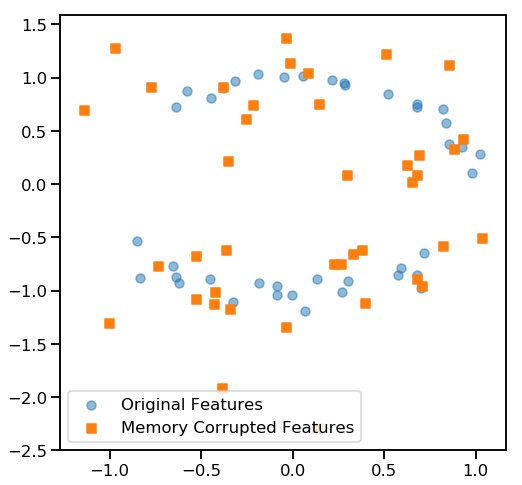

In [14]:
# plot the corrupted features
x_mem = np.concatenate([y_mem0[0].reshape(1, -1) for y_mem0 in y_mem])
# plt.plot()
plt.figure(figsize=(8,8))
plt.scatter(x_train[:, 0], x_train[:, 1], alpha=0.5, label='Original Features')
plt.scatter(x_mem[:, 0], x_mem[:, 1], marker='s', label='Memory Corrupted Features')
plt.legend()

## Reconstruction
As before, there is a function in the memory module to perform reconstruction.  We just need to set parameters

In [15]:
from models.memory import gibbs_memory_sampler
help(gibbs_memory_sampler)

Help on function gibbs_memory_sampler in module models.memory:

gibbs_memory_sampler(y_mem, sem_model, memory_alpha, memory_lambda, memory_epsilon, b, tau, n_samples=250, n_burnin=100, progress_bar=True, leave_progress_bar=True)
    :param y_mem: list of 3-tuples (x_mem, e_mem, t_mem), corrupted memory trace
    :param sem_mdoel: trained SEM instance
    :param memory_alpha: SEM alpha parameter to use in reconstruction
    :param memory_labmda: SEM lmbda parameter to use in reconstruction
    :param memory_epsilon: (float) parameter controlling propensity to include null trace in reconstruction
    :param b: (int) time index corruption noise
    :param tau: (float, greater than zero) feature vector corruption noise
    :param n_burnin: (int, default 100) number of Gibbs sampling itterations to burn in
    :param n_samples: (int, default 250) number of Gibbs sampling itterations to collect
    :param progress_bar: (bool) use progress bar for sampling?
    :param leave_progress_bar: (boo

In [16]:
gibbs_memory_kwargs = dict(
    y_mem=y_mem, sem_model=sem_model,
    memory_alpha = sem_kwargs['alfa'],
    memory_lambda = sem_kwargs['lmda'],
    memory_epsilon = np.exp(-10),
    b = noise_kwargs['b'],
    tau = noise_kwargs['tau'],
)

y_samp, e_samp, x_samp = gibbs_memory_sampler(**gibbs_memory_kwargs)

Gibbs Sampler: 100%|██████████| 350/350 [01:23<00:00,  3.20it/s]


In [17]:
from models.memory import reconstruction_accuracy, evaluate_seg

print "total reconstruction accuracy: {}".format(reconstruction_accuracy(y_samp, y_mem).mean())
# this metric evaluates the proportion of time each memory trace is included in the sample.
# It is a useful diagnositic and sometimes useful to think of this as recall.

print "reconstruction segmentation: {}".format(evaluate_seg(e_samp, e_true))
## How well the memory model recovered the segmentation is also a useful diagnostic

total reconstruction accuracy: 0.8145
reconstruction segmentation: 0.8662


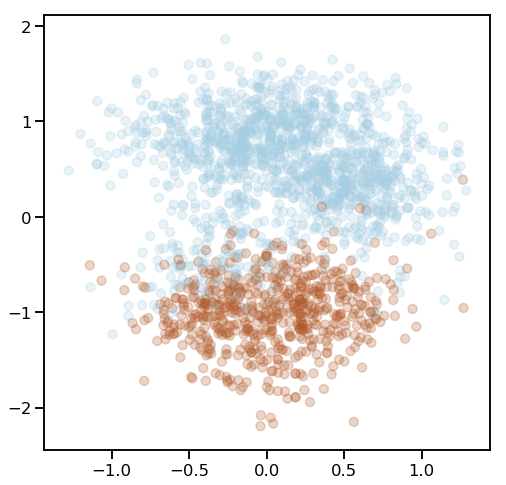

In [18]:
plt.figure(figsize=(8,8))


for ii in range(50):
    plt.scatter(x_samp[ii][:, 0], x_samp[ii][:, 1], alpha=0.25, c=e_samp[ii], cmap='Paired')

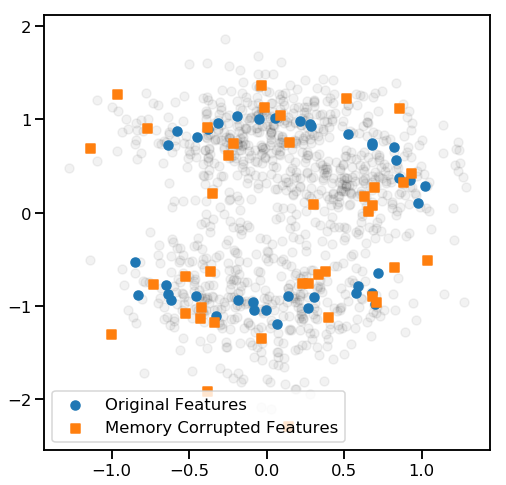

In [19]:
plt.figure(figsize=(8,8))

for ii in range(25):
    plt.scatter(x_samp[ii][:, 0], x_samp[ii][:, 1], alpha=0.05, c='k')

plt.scatter(x_train[:, 0], x_train[:, 1], label='Original Features')
plt.scatter(x_mem[:, 0], x_mem[:, 1], marker='s', label='Memory Corrupted Features')
plt.legend()

## Comparison to a Hidden Markov Model (HMM)

We can also compare SEM to a reduced model that infers events but does not learn event dynamics (a.k.a. a Hidden Markov Model). These models typically do well in segmentation, but are less often used as memory models (to our knoweldge).

In [20]:
from models.event_models import StationaryEvent

# copy the original segementation parameters and change the event model class to
# a stationary emmision distribution
hmm_kwargs = {k: v for k, v in sem_kwargs.iteritems()}
hmm_kwargs['f_class'] = StationaryEvent

hmm_model = SEM(**hmm_kwargs)
post = hmm_model.run(x_train)
y_hat_hmm = np.argmax(post, axis=1)
print "Adjusted Rand Score: ", metrics.adjusted_rand_score(y, y_hat_hmm)

# copy the gibbs parameters and just update the model
gibbs_memory_kwargs_hmm = {k: v for k, v in gibbs_memory_kwargs.iteritems()}
gibbs_memory_kwargs_hmm['sem_model'] = hmm_model

y_samp_hmm, e_samp_hmm, x_samp_hmm = gibbs_memory_sampler(**gibbs_memory_kwargs_hmm)


Gibbs Sampler:   0%|          | 0/350 [00:00<?, ?it/s]

Adjusted Rand Score:  1.0


Gibbs Sampler: 100%|██████████| 350/350 [01:26<00:00,  3.35it/s]


The HMM does a good job of segmentation but how good is it as a memory model? We can compare the reconstructed scenes for both SEM and the HMM by comparing the distribution of distances between the original scenes and the reconstructed equivalents.  

/Users/nicholasfranklin/anaconda3/envs/sem/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


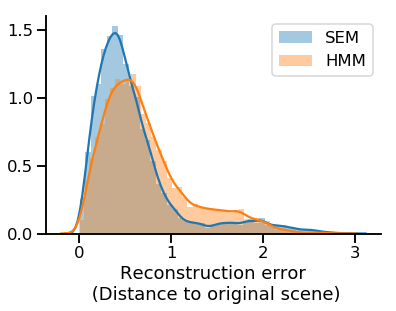

In [21]:
def get_dist(a, b):
    return np.linalg.norm(a - b, axis=1)

sns.distplot(np.concatenate([get_dist(x0, x_train) for x0 in x_samp]), label='SEM')
sns.distplot(np.concatenate([get_dist(x0, x_train) for x0 in x_samp_hmm]), label='HMM')
plt.xlabel('Reconstruction error\n (Distance to original scene)')
plt.legend()
sns.despine()

A key prediction of SEM is that memory traces are regularized towards the event dynamics, and not towards a global average of all scenes within an event. 

To calculate this, we get the distance between:
1. each reconstructed feature and both the the original scene
2. each reconstructed feature and the average scene with the (inferred) event.

If (1) is greater than (2), then the model as regularized towards the event trajectory.  If (2) is greater than (1), then the model has regularized towards the centroid.  For simplicity, we just plot the relative difference between these two here, with a postive value indicating regularization towards the original scene and a negative value indicating regularization towards the centroid.

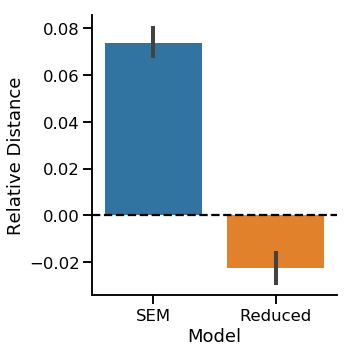

In [22]:
import pandas as pd
event_centroids = np.concatenate([
    np.tile(x_train[e_true == 0, :].mean(axis=0), (20, 1)),
    np.tile(x_train[e_true == 1, :].mean(axis=0), (20, 1))
])

sem_reld = np.concatenate([-get_dist(x0, x_train) + get_dist(x0, event_centroids) for x0 in x_samp])
red_reld = np.concatenate([-get_dist(x0, x_train) + get_dist(x0, event_centroids) for x0 in x_samp_hmm])

df = pd.DataFrame(
    {
        'Model': ['SEM'] * len(sem_reld) + ['Reduced'] * len(red_reld),
        'Relative Distance': np.concatenate([sem_reld, red_reld])
    })
sns.catplot(data=df, x='Model', y='Relative Distance', kind='bar')
plt.axhline(y=0, ls='--', c='k')

As we can see, SEM regularizes towards the memory trace and the HMM regularizes toward the avewrage scene